# Adding Stolen Bases to OPS to create a new Offensive Metric in Baseball

### Data Loading and Transformation

In [1]:
# Import packages
import pandas as pd

In [3]:
# Load data
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Advanced Sports Analytics/data/adding_stolen_bases_to_ops.csv'
df = pd.read_csv(path)

Mounted at /content/drive


In [4]:
# Drop unnecessary columns
cols_to_drop = [
    "Rk", "Age", "Team", "Lg", "WAR", "G", "R", "RBI", "SO", "OPS+", "rOBA", "Rbat+", "TB", "GIDP", "Pos", "Awards", "Player-additional"
]
df = df.drop(columns=cols_to_drop, errors='ignore')

# Data check
df.head()

,Player,PA▼,AB,H,2B,3B,HR,SB,CS,BB,BA,OBP,SLG,OPS,HBP,SH,SF,IBB
0,Francisco Lindor#,732,644,172,35,0,31,31,6,65,0.267,0.346,0.466,0.811,16,0,7,2
1,Rafael Devers*,729,607,153,33,0,35,1,1,112,0.252,0.372,0.479,0.851,6,0,4,10
2,Shohei Ohtani*,727,611,172,25,9,55,20,6,109,0.282,0.392,0.622,1.014,3,0,2,20
3,Matt Olson*,724,624,170,41,2,29,1,0,91,0.272,0.366,0.484,0.850,4,0,5,2
4,Kyle Schwarber*,724,604,145,23,2,56,10,2,108,0.240,0.365,0.563,0.928,11,0,1,6


In [ ]:
# Compute singles
df["1B"] = df["H"] - (df["2B"] + df["3B"] + df["HR"])

# Adjust singles for SB and CS
df["adj_1B"] = df["1B"] - df["SB"] - df["CS"]

# Adjust doubles for SB and CS
df["adj_2B"] = df["2B"] + df["SB"]

# Adjust hits for SB and CS
df["adj_H"] = df["adj_1B"] + df["adj_2B"] + df["3B"] + df["HR"]

# Total bases including SB adjustments
df["TB_wSB"] = ((1 * df["adj_1B"]) + (2 * df["adj_2B"]) + (3 * df["3B"]) + (4 * df["HR"]))

# OBP including including SB adjustments
df["OBP_wSB"] = (df["adj_H"] + df["BB"] + df["HBP"]) / (df["AB"] + df["BB"] + df["HBP"] + df["SF"])

# SLG including SB adjustments
df["SLG_wSB"] = df["TB_wSB"] / df["AB"]

# OPSwSB
df["OPSwSB"] = df["OBP_wSB"] + df["SLG_wSB"]

# Deviation
df["OPS_diff"] = df["OPSwSB"] - df["OPS"]

# Data Check
df[["Player", "OBP", "SLG", "OPS", "OBP_wSB", "SLG_wSB", "OPSwSB", "OPS_diff"]].head()

,Player,OBP,SLG,OPS,OBP_wSB,SLG_wSB,OPSwSB,OPS_diff
0,Francisco Lindor#,0.346,0.466,0.811,0.337432,0.504658,0.842090,0.031090
1,Rafael Devers*,0.372,0.479,0.851,0.370370,0.479407,0.849777,-0.001223
2,Shohei Ohtani*,0.392,0.622,1.014,0.383448,0.644845,1.028293,0.014293
3,Matt Olson*,0.366,0.484,0.850,0.366022,0.485577,0.851599,0.001599
4,Kyle Schwarber*,0.365,0.563,0.928,0.361878,0.576159,0.938037,0.010037


### Data Visualization

In [ ]:
# Import
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

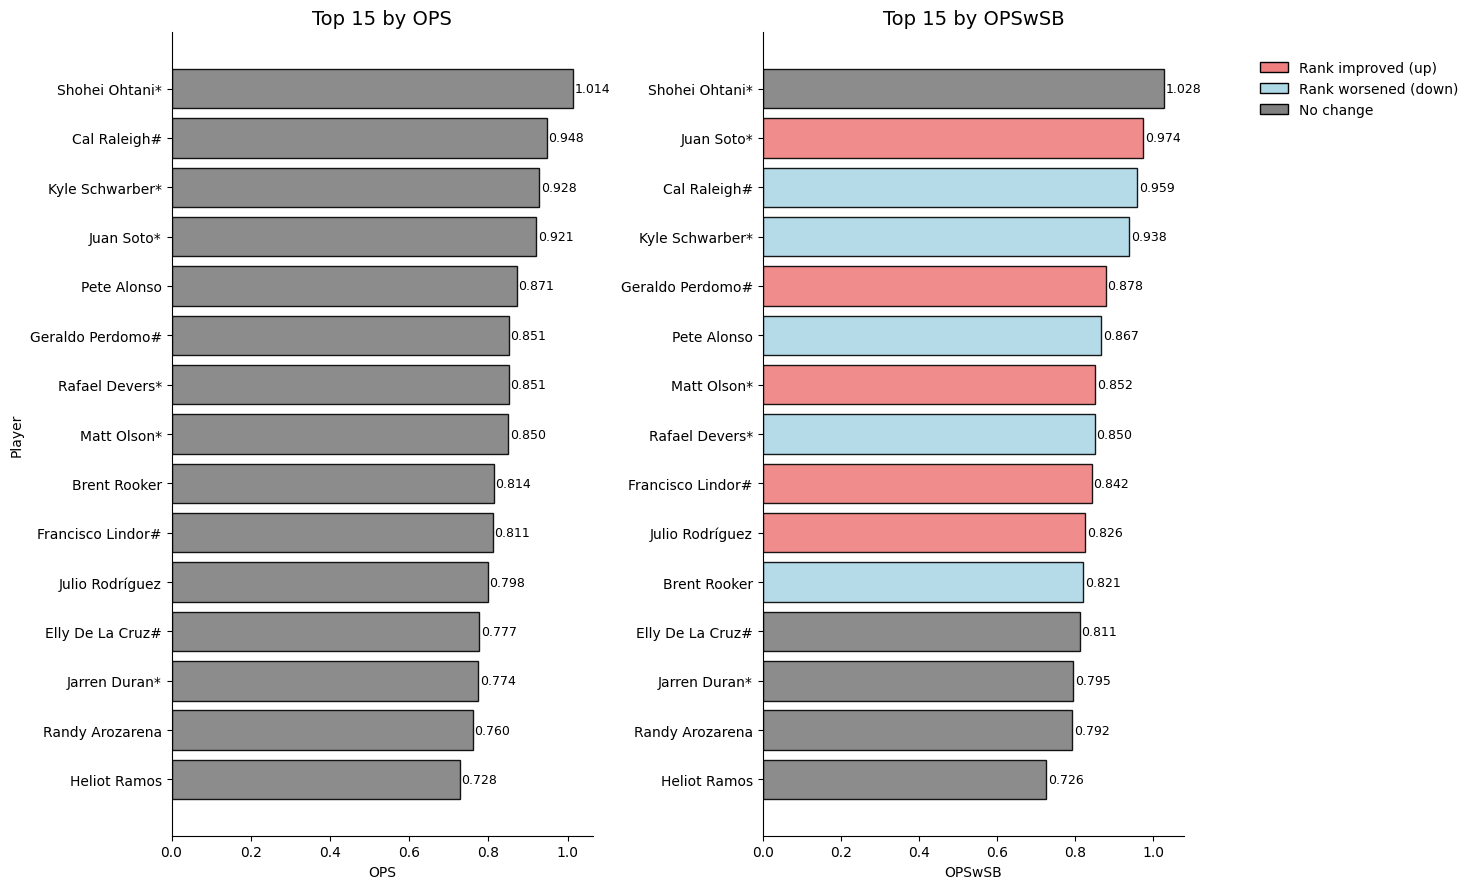

In [ ]:
# Run window functions
df["rank_OPS"] = df["OPS"].rank(ascending=False, method="min").astype("Int64")
df["rank_OPSwSB"] = df["OPSwSB"].rank(ascending=False, method="min").astype("Int64")\

# Rank the delta
df["rank_delta"] = df["rank_OPSwSB"] - df["rank_OPS"]

# Create sort for the left chart
left = df.sort_values("rank_OPS", ascending=False)

# Create sort for the right chart
right = df.sort_values("rank_OPSwSB", ascending=False)


# Colors for right chart based on rank movement
def color_by_rank_delta(d):
    if pd.isna(d) or d == 0:
        return "gray"
    if d < 0:
        return "lightcoral"
    return "lightblue"

right_colors = right["rank_delta"].apply(color_by_rank_delta).tolist()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9), sharey=False)


# Left chart
ax1.barh(left["Player"], left["OPS"], color="gray", edgecolor="black", alpha=0.9)
ax1.set_title("Top 15 by OPS", fontsize=14)
ax1.set_xlabel("OPS")
ax1.set_ylabel("Player")
for y, v in enumerate(left["OPS"].to_numpy()):
    ax1.text(v + 0.004, y, f"{v:.3f}", va="center", fontsize=9)

# Right Chart
ax2.barh(right["Player"], right["OPSwSB"], color=right_colors, edgecolor="black", alpha=0.9)
ax2.set_title("Top 15 by OPSwSB", fontsize=14)
ax2.set_xlabel("OPSwSB")
ax2.set_ylabel("")
for y, v in enumerate(right["OPSwSB"].to_numpy()):
    ax2.text(v + 0.004, y, f"{v:.3f}", va="center", fontsize=9)

# Tidy up
for ax in (ax1, ax2):
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params(axis="y", labelsize=10)
    ax.tick_params(axis="x", labelsize=10)

# Small legends for right chart
legend_patches = [Patch(facecolor="lightcoral", edgecolor="black", label="Rank improved (up)"), Patch(facecolor="lightblue", edgecolor="black", label="Rank worsened (down)"), Patch(facecolor="gray", edgecolor="black", label="No change"),]
ax2.legend(handles=legend_patches, loc="center left", bbox_to_anchor=(1.15, 0.93), frameon=False, fontsize=10)

plt.tight_layout()
plt.show()